<a href="https://colab.research.google.com/github/Sanmay-Das/Joy-o-meter/blob/main/Joy_o_Meter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementation of a simple linear neural network that reads in text and uses pretrained embeddings to predict the happiness intensity of the text.

In [1]:
!pip install fastapi uvicorn transformers torch pyngrok nest_asyncio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.

In [2]:
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn
import nest_asyncio
%matplotlib inline

In [3]:
app = FastAPI()

In [4]:
# Load dataset and visualize
train_file = 'EI-reg-En-joy-train.txt'
val_file = '2018-EI-reg-En-joy-dev.txt'
df_train = pd.read_csv(train_file, sep='\t')
df_val = pd.read_csv(val_file, sep='\t')

tweets_train = df_train['Tweet'].tolist()  # Create a list of tweets
tweets_val = df_val['Tweet'].tolist()

# Create a list of intensity scores
y_train = torch.tensor(df_train['Intensity Score'], dtype=torch.float32)  # match to dtype of embedding
y_val = torch.tensor(df_val['Intensity Score'], dtype=torch.float32)

print('Score - Tweet')
for i in range(5):
    print('{:0.2f} - {}'.format(y_train[i], tweets_train[i]))

Score - Tweet
0.14 - @david_garrett Quite saddened.....no US dates, no joyous anticipation of attending a DG concert (since 2014). Happy you are keeping busy.
0.79 - 2 days until #GoPackGo and 23 days until #GoGipeGo..... I'm so excited! 
0.27 - Positive #psychology research shows salespeople who score in the top 10% for #optimism have 88% &gt; sales than those in top 10% for pessimism.
0.48 - As the birds chirp and the cows moo we need to listen to the sound of nature to ensure that all is well.
0.94 - Howling with laughter at “WELL DONE BEZZA!” #bakeoff #GBBO


In [5]:
# Load a pretrained transformer model and tokenizer
bert_model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModel.from_pretrained(bert_model_name)

# Function to convert a sentence into an embedding
def embed_sentence(bert_model, tokenizer, sentence):
    """Encodes a sentence using a pretrained BERT model."""
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)

    # Ensure correct model is used
    with torch.no_grad():
        outputs = bert_model(**inputs)  # Corrected: explicitly use bert_model

    # Extract the mean of all token embeddings to get a single vector
    sentence_embedding = outputs.last_hidden_state.mean(dim=1)

    return sentence_embedding


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
# Convert all tweets into embeddings
X_train = torch.stack([embed_sentence(bert_model, tokenizer, tweet) for tweet in tweets_train]).squeeze()
X_val = torch.stack([embed_sentence(bert_model, tokenizer, tweet) for tweet in tweets_val]).squeeze()

# Print shape of processed data
print(X_train.shape, X_val.shape)  # Should be (num_samples, embedding_dim)


torch.Size([1616, 768]) torch.Size([290, 768])


In [7]:
class MyLinearNet(torch.nn.Module):
    def __init__(self, input_embedding_size):
        super().__init__()
        self.d = input_embedding_size  # Store embedding size
        self.w = torch.nn.Parameter(torch.randn(self.d))  # Weights
        self.b = torch.nn.Parameter(torch.randn(1))  # Bias

    def forward(self, X):
        return X @ self.w + self.b  # Linear transformation

    def fit(self, X, y, gamma=0.0):
        """Fit model parameters analytically using linear regression formula."""
        N, d = X.shape
        X_aug = torch.cat([X, torch.ones(N, 1)], dim=1)  # Augment with bias term
        I = torch.eye(d + 1)
        w_solution = torch.linalg.inv(X_aug.T @ X_aug + gamma * I) @ X_aug.T @ y
        self.w.data = w_solution[:-1]
        self.b.data = w_solution[-1]


In [8]:
linear_model = MyLinearNet(768)
#linear_model.load_state_dict(torch.load("linear_model.pth", map_location=torch.device('cpu')))
linear_model.eval()

MyLinearNet()

In [9]:
def loss(model, X, y):
    y_pred = model(X)
    return ((y - y_pred) ** 2).mean()  # Mean Squared Error


In [10]:
class TextRequest(BaseModel):
    text: str

In [11]:
@app.post("/predict/")
async def predict_happiness(request: TextRequest):
    embedding = embed_sentence(request.text)
    with torch.no_grad():
        score = linear_model(embedding).item()
    return {"happiness_score": round(score, 2)}

In [12]:
!pip install pyngrok
from pyngrok import ngrok

# Replace YOUR_AUTH_TOKEN with the token you copied from the ngrok website
!ngrok authtoken 2q8xvyvFK0ycfril3ahpj2lOeN4_7Ujjr35cgjXjnEZXEKE23


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [13]:
nest_asyncio.apply()

In [14]:
def run():
  uvicorn.run(app, host="0.0.0.0", port=8000)

In [15]:
import threading
threading.Thread(target=run).start()

In [17]:
public_url = ngrok.connect(addr="8000",proto='http')
print("Public URL:",public_url)

Public URL: NgrokTunnel: "https://19f1-34-58-90-74.ngrok-free.app" -> "http://localhost:8000"


In [ ]:
d = X_train.shape[1]
model = MyLinearNet(d)

# Before training
loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)
print(f"Loss BEFORE fitting:\nTrain: {loss_train:.3f}, Val: {loss_val:.3f}")

# Fit model analytically
model.fit(X_train, y_train, gamma=0.0)

# After training without regularization
loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)
print(f"Loss AFTER fitting WITHOUT regularization:\nTrain: {loss_train:.3f}, Val: {loss_val:.3f}")

# Train with regularization (L2)
model.fit(X_train, y_train, gamma=0.1)

loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)
print(f"Loss AFTER fitting WITH regularization:\nTrain: {loss_train:.3f}, Val: {loss_val:.3f}")


Loss BEFORE fitting:
Train: 47.606, Val: 41.593
Loss AFTER fitting WITHOUT regularization:
Train: 0.685, Val: 1.004
Loss AFTER fitting WITH regularization:
Train: 0.009, Val: 0.042


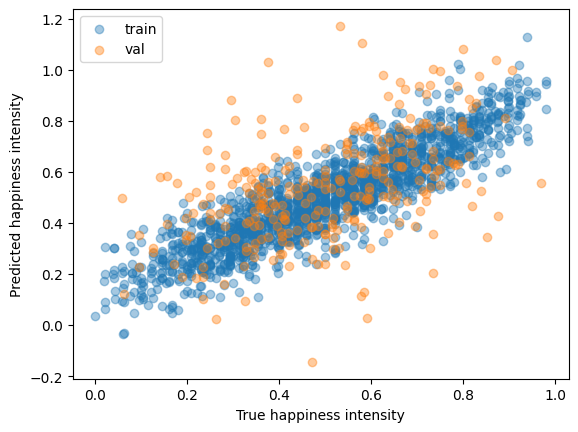

In [ ]:
def plot(y_true_train, y_pred_train, y_true_val, y_pred_val):
    fig, ax = plt.subplots()
    ax.scatter(y_true_train, y_pred_train, alpha=0.4, label="train")
    ax.scatter(y_true_val, y_pred_val, alpha=0.4, label="val")
    ax.set_xlabel("True happiness intensity")
    ax.set_ylabel("Predicted happiness intensity")
    ax.legend()
    plt.show()

# Get predictions
with torch.no_grad():
    y_hat_train = model(X_train)
    y_hat_val = model(X_val)

plot(y_train, y_hat_train, y_val, y_hat_val)


In [ ]:
happy_tweet = "I am so excited for the weekend! Life is beautiful."
sad_tweet = "I feel so down today. Everything is going wrong."

# Generate embeddings using BERT model (NOT MyLinearNet)
happy_embedding = embed_sentence(bert_model, tokenizer, happy_tweet)
sad_embedding = embed_sentence(bert_model, tokenizer, sad_tweet)

print(happy_embedding.shape)
print(sad_embedding.shape)



torch.Size([1, 768])
torch.Size([1, 768])
